In [46]:
# KOMÓRKA #1 — IMPORTY (TYLKO TUTAJ)
import os, sys, hashlib, pathlib, time, math, shutil
from typing import Optional
from urllib.request import urlopen, Request
import cv2                        # obsługa kamery/wideo (OpenCV)
import mediapipe as mp            # Face Mesh 468 (użyjemy za chwilę)
import numpy as np                # operacje na macierzach/obrazach
import torch                      # PyTorch (model emocji)
import torch.nn as nn             # sieci neuronowe
import torch.nn.functional as F   # funkcje aktywacji itp.
from torchvision import models    # modele i transformacje obrazów
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image as PILImage # obsługa obrazów (PIL)
import matplotlib.pyplot as plt   # PODGLĄD miniatur kamer
from pathlib import Path         # obsługa ścieżek plików
from huggingface_hub import hf_hub_download # pobieranie modelu z HF

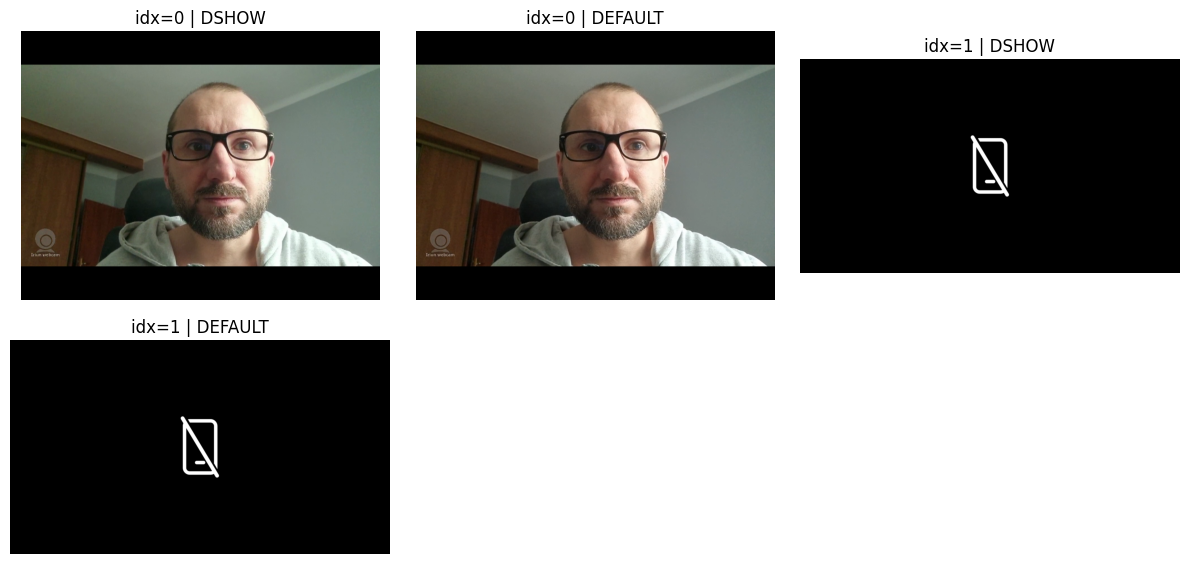

Kandydaci: [(0, 'DSHOW'), (0, 'DEFAULT'), (1, 'DSHOW'), (1, 'DEFAULT')]


In [3]:
# Skanuje indeksy 0..max_index, pokazuje miniatury z kamer i zwraca listę kandydatów
def _grab_frame(idx: int, api: int | None, warmup: int = 5):
    cap = cv2.VideoCapture(idx, api) if api is not None else cv2.VideoCapture(idx)
    if not cap.isOpened():
        return None
    # krótka rozgrzewka (niektóre sterowniki oddają czarną 1. klatkę)
    for _ in range(warmup):
        ok, _ = cap.read()
        if not ok:
            cap.release()
            return None
    ok, frame = cap.read()
    cap.release()
    if not ok or frame is None:
        return None
    return frame

def scan_cameras(max_index: int = 6, try_both_apis: bool = True):
    """
    Zwraca listę: [(idx, api_name, frame_rgb), ...]
    api_name ∈ {"DSHOW","DEFAULT"}
    """
    candidates = []
    api_options = [("DSHOW", cv2.CAP_DSHOW)] if try_both_apis else [("DEFAULT", None)]
    if try_both_apis:
        api_options.append(("DEFAULT", None))

    for i in range(max_index + 1):
        for api_name, api in api_options:
            frame = _grab_frame(i, api)
            if frame is not None:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                candidates.append((i, api_name, rgb))
                # nie przerywamy — pokazujemy wszystkie źródła (masz 2 telefony)
    return candidates

cands = scan_cameras(max_index=6, try_both_apis=True)

# Wizualizacja miniatur
if not cands:
    print("Nie znaleziono żadnej działającej kamery w indeksach 0..6.")
else:
    n = len(cands)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for k, (idx, api_name, rgb) in enumerate(cands, start=1):
        plt.subplot(rows, cols, k)
        plt.imshow(rgb)
        plt.title(f"idx={idx} | {api_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Lista kandydatów do szybkiej referencji:
cands_summary = [(idx, api) for (idx, api, _) in [(i, a, f) for i,a,f in cands]]
print("Kandydaci:", cands_summary)

## USTAW INDEX KAMERY

OK — jedna klatka: (480, 640, 3)


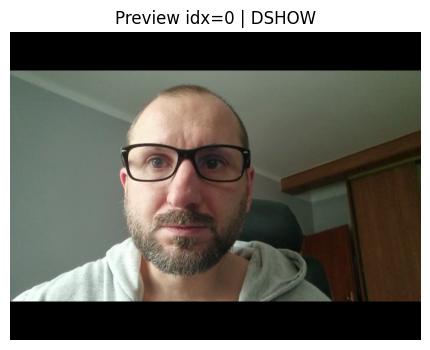

In [4]:
# USTAW tutaj wybraną parę z listy miniatur (patrz tytuły na obrazkach):
CAM_INDEX = 0       # <- wpisz właściwy idx z miniatur
CAM_API_NAME = "DSHOW"  # "DSHOW" albo "DEFAULT"

CAM_API = cv2.CAP_DSHOW if CAM_API_NAME.upper() == "DSHOW" else None

# Szybki test: jedna klatka + info o rozmiarze
frame = _grab_frame(CAM_INDEX, CAM_API)
assert frame is not None, f"Nie udało się pobrać klatki z idx={CAM_INDEX}, api={CAM_API_NAME}"
print("OK — jedna klatka:", frame.shape)

# podgląd w matplotlib (lustrzane jak w Iriun)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(cv2.flip(frame, 1), cv2.COLOR_BGR2RGB))
plt.title(f"Preview idx={CAM_INDEX} | {CAM_API_NAME}")
plt.axis("off")
plt.show()

d:\Programowanie\Python\Envs\ml-pytorch-face\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


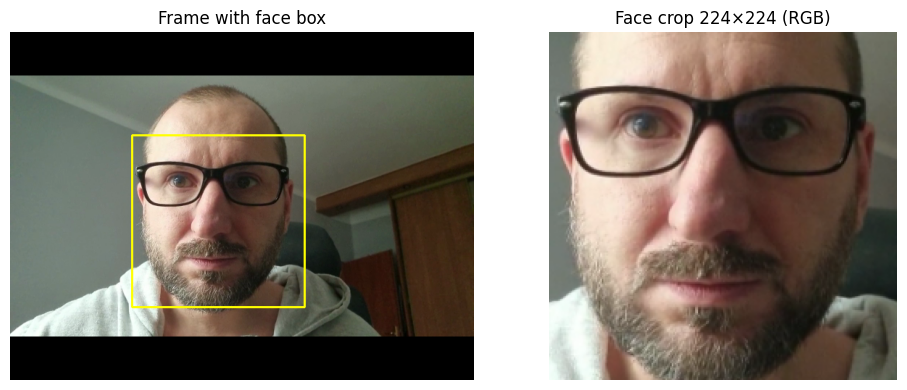

In [ ]:
# 1) Skrót do detektora twarzy
mp_fd = mp.solutions.face_detection

# 2) Jedna klatka z wybranej kamery
frame_bgr = _grab_frame(CAM_INDEX, cv2.CAP_DSHOW if CAM_API_NAME.upper()=="DSHOW" else None)
assert frame_bgr is not None, f"Cannot read a frame from idx={CAM_INDEX} ({CAM_API_NAME})."

# 3) Mirror (jak w Iriun)
frame_bgr = cv2.flip(frame_bgr, 1)

# 4) Detekcja twarzy (MediaPipe)
with mp_fd.FaceDetection(model_selection=0, min_detection_confidence=0.4) as fd:
    frame_rgb_full = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    res = fd.process(frame_rgb_full)

if not res.detections:
    raise RuntimeError("No face detected in the current frame. Look at the camera and improve lighting.")

# 5) Przeliczenie boxa relatywnego na piksele
det = res.detections[0]
H, W = frame_bgr.shape[:2]
bb = det.location_data.relative_bounding_box
x1 = max(0, int(bb.xmin * W)); y1 = max(0, int(bb.ymin * H))
x2 = min(W, int((bb.xmin + bb.width) * W))
y2 = min(H, int((bb.ymin + bb.height) * H))

# 6) Wycięcie twarzy w BGR + konwersja do RGB (modele ImageNet oczekują RGB)
face_bgr = frame_bgr[y1:y2, x1:x2]
assert face_bgr.size > 0, "Detected box is empty — check the frame dimensions."
face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)

# 7) Zmiana rozdzielczości do 224×224 (INTER_AREA przy zmniejszaniu)
face_224 = cv2.resize(face_rgb, (224, 224), interpolation=cv2.INTER_AREA)

# 8) Podgląd: pełna klatka z ramką + crop 224×224 (w kolorze)
frame_vis = frame_bgr.copy()
cv2.rectangle(frame_vis, (x1, y1), (x2, y2), (0, 255, 255), 2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB)); plt.title("Frame with face box"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(face_224); plt.title("Face crop 224×224 (RGB)"); plt.axis("off")
plt.tight_layout(); plt.show()

# 9) Zapisz do zmiennych „na później” (predyktor 224×224 użyje face_224)
FACE_CROP_224 = face_224      # RGB 224×224
FACE_BBOX     = (x1, y1, x2, y2)

In [33]:
def get_model(num_classes: int,
              pretrained: bool = True,
              dropout_p: float = 0.2,
              freeze_backbone: bool = False) -> nn.Module:
    weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = resnet18(weights=weights)

    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False

    in_features = model.fc.in_features  # RN18: 512
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

In [35]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [36]:
import torch.optim as optim

model = get_model(num_classes=7, pretrained=True, dropout_p=0.2, freeze_backbone=False)

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
# albo różnicowane LR:
# head_params = list(model.fc.parameters())
# backbone_params = [p for n,p in model.named_parameters() if not n.startswith('fc.')]
# optimizer = optim.AdamW([
#     {'params': backbone_params, 'lr': 1e-4},
#     {'params': head_params, 'lr': 1e-3}
# ], weight_decay=1e-4)

In [47]:
def ensure_weights_local(
    local_path: str,
    hf_repo_id: str,
    hf_filename: str,
    hf_token: Optional[str] = None,
    expected_sha256: Optional[str] = None,
) -> str:
    """
    Upewnia się, że plik wag istnieje lokalnie. Jeśli nie istnieje – pobiera z Hugging Face.
    
    Args:
        local_path: pełna ścieżka docelowa do pliku wag (np. r"d:\...\weights\resnet18_fer2013_best.pth")
        hf_repo_id: repo na HF (np. "user_or_org/project")
        hf_filename: nazwa pliku w repo (np. "resnet18_fer2013_best.pth" lub "weights/resnet18_best.pth")
        hf_token: opcjonalny token dla repo prywatnych (str lub None)
        expected_sha256: opcjonalna suma SHA-256 do weryfikacji integralności

    Returns:
        Ścieżka do lokalnego pliku wag (string).

    Raises:
        FileNotFoundError: gdy nie udało się pobrać pliku.
        ValueError: gdy weryfikacja SHA-256 nie powiedzie się.
    """
    local_path = Path(local_path)
    local_path.parent.mkdir(parents=True, exist_ok=True)

    def _sha256(path: Path) -> str:
        h = hashlib.sha256()
        with path.open("rb") as f:
            for chunk in iter(lambda: f.read(1024 * 1024), b""):
                h.update(chunk)
        return h.hexdigest()

    # 1) Jeśli istnieje lokalnie — ewentualnie zweryfikuj hash i wyjdź
    if local_path.exists():
        if expected_sha256:
            got = _sha256(local_path)
            if got.lower() != expected_sha256.lower():
                raise ValueError(
                    f"Plik '{local_path}' istnieje, ale SHA-256 się nie zgadza.\n"
                    f"  expected: {expected_sha256}\n  got:      {got}"
                )
        return str(local_path)

    # 2) Brak lokalnie — pobierz z HF do cache
    try:
        cache_path = hf_hub_download(
            repo_id=hf_repo_id,
            filename=hf_filename,
            token=hf_token,
            resume_download=True,
        )
    except Exception as e:
        raise FileNotFoundError(
            f"Nie udało się pobrać z Hugging Face: {hf_repo_id}/{hf_filename}\n"
            f"Powód: {e}\n"
            f"Sprawdź: nazwy, uprawnienia (token), istnienie pliku w repo."
    )

    # 4) Skopiuj (rename bezpieczny między dyskami -> write/read)
    data = cache_path.read_bytes()
    local_path.write_bytes(data)

    return str(local_path)


In [49]:
import os

# >>> WSTAW SWOJE KONKRETNE DANE <<<
os.environ["HF_REPO_ID"]  = "twoj_user/face-emotion-weights"   # np. "crispotter/face-emotion-weights"
os.environ["HF_FILENAME"] = "resnet18_fer2013_best.pth"        # dokładna nazwa pliku w repo
# os.environ["HF_TOKEN"]  = "hf_xxx"                            # jeśli repo prywatne
# os.environ["HF_SHA256"] = "..."                               # opcjonalnie: suma kontrolna

# Krótka diagnostyka:
print("HF_REPO_ID =", os.getenv("HF_REPO_ID"))
print("HF_FILENAME =", os.getenv("HF_FILENAME"))
print("HF_TOKEN set? ", "YES" if os.getenv("HF_TOKEN") else "NO")

HF_REPO_ID = twoj_user/face-emotion-weights
HF_FILENAME = resnet18_fer2013_best.pth
HF_TOKEN set?  NO


In [51]:
# Domyślne ścieżki/zmienne (zmień pod swój projekt)
WEIGHTS_LOCAL_PATH = r"d:\Programowanie\Python\Projects\face_emotion_detector_best\weights\resnet18-5c106cde.pth"

# Zmiennie środowiskowe (ustaw wcześniej w systemie lub tutaj przed wywołaniem)
HF_REPO_ID   = os.getenv("HF_REPO_ID")       # np. "twoj_user/face-emotion-weights"
HF_FILENAME  = os.getenv("HF_FILENAME")      # np. "resnet18_fer2013_best.pth"
HF_TOKEN     = os.getenv("HF_TOKEN")         # jeśli repo prywatne, inaczej None
HF_SHA256    = os.getenv("HF_SHA256")        # opcjonalnie: oczekiwany hash

# Wywołanie
weights_path = ensure_weights_local(
    local_path=WEIGHTS_LOCAL_PATH,
    hf_repo_id=HF_REPO_ID,
    hf_filename=HF_FILENAME,
    hf_token=HF_TOKEN,
    expected_sha256=HF_SHA256
)
print("Wagi gotowe pod:", weights_path)

Wagi gotowe pod: d:\Programowanie\Python\Projects\face_emotion_detector_best\weights\resnet18-5c106cde.pth


In [52]:
p = Path(WEIGHTS_LOCAL_PATH)
assert p.exists() and p.is_file(), f"Brak pliku wag: {p}"

def sha256(path: Path) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(1024*1024), b""):
            h.update(chunk)
    return h.hexdigest()

print("Plik OK, rozmiar:", p.stat().st_size, "B")
print("SHA-256:", sha256(p))

Plik OK, rozmiar: 46827520 B
SHA-256: 5c106cde386e87d4033832f2996f5493238eda96ccf559d1d62760c4de0613f8


In [56]:
# Wczytaj plik .pth w legacy formacie (oficjalny PyTorch) — świadomie wyłączamy weights_only
try:
    sd_obj = torch.load(WEIGHTS_LOCAL_PATH, map_location="cpu", weights_only=False)
except TypeError:
    # Dla starszych wersji torch bez parametru weights_only
    sd_obj = torch.load(WEIGHTS_LOCAL_PATH, map_location="cpu")

# Różne warianty zapisu: czysty state_dict albo checkpoint z kluczem 'state_dict'/'model'
if isinstance(sd_obj, dict) and "state_dict" in sd_obj and isinstance(sd_obj["state_dict"], dict):
    sd = sd_obj["state_dict"]
elif isinstance(sd_obj, dict) and all(isinstance(v, torch.Tensor) for v in sd_obj.values()):
    sd = sd_obj  # czysty state_dict
elif isinstance(sd_obj, dict) and "model" in sd_obj and isinstance(sd_obj["model"], dict):
    sd = sd_obj["model"]
else:
    raise ValueError("Nie rozpoznano formatu wag: to nie wygląda na state_dict.")

# Usuwanie prefiksu 'module.' jeśli wagi zapisano z DataParallel
first_key = next(iter(sd.keys()))
if first_key.startswith("module."):
    sd = {k.replace("module.", "", 1): v for k, v in sd.items()}

print("Załadowano state_dict z", len(sd), "kluczami.")

Załadowano state_dict z 102 kluczami.


In [57]:
m_test = resnet18(weights=None)
missing, unexpected = m_test.load_state_dict(sd, strict=False)
print("missing:", len(missing), "→", missing[:6])
print("unexpected:", len(unexpected), "→", unexpected[:6])

# Spodziewamy się fc dla 1000 klas (ImageNet)
fc_w = sd.get("fc.weight", None)
fc_b = sd.get("fc.bias", None)
assert fc_w is not None and fc_b is not None, "Brakuje kluczy fc.weight/fc.bias"
print("fc.weight shape:", tuple(fc_w.shape))  # (1000, 512)
print("fc.bias   shape:", tuple(fc_b.shape))  # (1000,)
assert fc_w.shape == (1000, 512) and fc_b.shape == (1000,), "To nie wygląda na oficjalne wagi ImageNet."

print("conv1.weight:", tuple(sd["conv1.weight"].shape))                 # (64, 3, 7, 7)
print("layer4.1.conv2.weight:", tuple(sd["layer4.1.conv2.weight"].shape))  # (512, 512, 3, 3)

# Strict=True powinno przejść
m_test = resnet18(weights=None)
m_test.load_state_dict(sd, strict=True)
print("Strict=True: PASSED ✅")

missing: 0 → []
unexpected: 0 → []
fc.weight shape: (1000, 512)
fc.bias   shape: (1000,)
conv1.weight: (64, 3, 7, 7)
layer4.1.conv2.weight: (512, 512, 3, 3)
Strict=True: PASSED ✅


In [58]:
model = resnet18(weights=None)
model.load_state_dict(sd, strict=True)

in_features = model.fc.in_features  # 512
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 7)
)

print("in_features (fc):", in_features)
print("Nowa głowica:", model.fc)
print("Weryfikacja + adaptacja zakończone ✅")

in_features (fc): 512
Nowa głowica: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=512, out_features=7, bias=True)
)
Weryfikacja + adaptacja zakończone ✅


In [59]:
def get_resnet18_model(num_classes: int = 7,
                       dropout_p: float = 0.2,
                       weights_path: str = None):
    """
    Tworzy ResNet-18, podmienia głowicę na num_classes i opcjonalnie wczytuje backbone z pliku wag (.pth/.safetensors).
    """
    model = resnet18(weights=None)  # nie pobieramy z internetu

    # Jeśli podasz ścieżkę do oficjalnych wag ImageNet (.pth) – wczytamy jako backbone
    if weights_path:
        try:
            sd_obj = torch.load(weights_path, map_location="cpu", weights_only=False)
        except TypeError:
            sd_obj = torch.load(weights_path, map_location="cpu")
        if isinstance(sd_obj, dict) and "state_dict" in sd_obj and isinstance(sd_obj["state_dict"], dict):
            sd = sd_obj["state_dict"]
        elif isinstance(sd_obj, dict) and all(isinstance(v, torch.Tensor) for v in sd_obj.values()):
            sd = sd_obj
        elif isinstance(sd_obj, dict) and "model" in sd_obj and isinstance(sd_obj["model"], dict):
            sd = sd_obj["model"]
        else:
            raise ValueError("Nie rozpoznano formatu wag: to nie wygląda na state_dict.")
        if next(iter(sd.keys())).startswith("module."):
            sd = {k.replace("module.", "", 1): v for k,v in sd.items()}
        model.load_state_dict(sd, strict=True)

    in_features = model.fc.in_features  # 512
    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

In [60]:
# Ustaw parametry
NUM_CLASSES   = 7
DROPOUT_P     = 0.2
LR_BACKBONE   = 1e-4
LR_HEAD       = 1e-3
WEIGHT_DECAY  = 1e-4
WEIGHTS_LOCAL_PATH = r"d:\Programowanie\Python\Projects\face_emotion_detector_best\weights\resnet18-5c106cde.pth"

# Budujemy model
model = get_resnet18_model(
    num_classes=NUM_CLASSES,
    dropout_p=DROPOUT_P,
    weights_path=WEIGHTS_LOCAL_PATH  # backbone z ImageNet
)

# Dwie grupy parametrów: backbone i head (szybsze uczenie głowicy)
head_params = list(model.fc.parameters())
backbone_params = [p for n,p in model.named_parameters() if not n.startswith('fc.')]

optimizer = torch.optim.AdamW([
    {"params": backbone_params, "lr": LR_BACKBONE},
    {"params": head_params,     "lr": LR_HEAD},
], weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()

# (opcjonalnie) scheduler – delikatny spadek LR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print("Model gotowy. Parametry LR:", [g["lr"] for g in optimizer.param_groups])

Model gotowy. Parametry LR: [0.0001, 0.001]


In [61]:
# Szybki test kształtów – sztuczna paczka (B=4, 3x224x224)
model.eval()
with torch.no_grad():
    x = torch.randn(4, 3, 224, 224)
    y = model(x)
print("Output shape:", tuple(y.shape))  # powinno być (4, 7)

Output shape: (4, 7)


In [62]:
from torchvision import transforms

IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
print("Transformaty gotowe.")

Transformaty gotowe.
